# MDA HW3 KMeans
# 105072123 黃海茵

## import

In [1]:
from pyspark import SparkConf, SparkContext
import pyspark
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv

## str_float
 * 為了方便計算，先把數字從string轉為float
 * 並把key都設為-1，就可以使用groupByKey

In [2]:
def str_float(line):
    for i in range(len(line)):
        line[i] = float(line[i])
        
    return (-1, line)

## Euc_Mapper
* 用來找出離該點最近的centroid，並設成key
* cost計算方式為Euclidean

In [3]:
def Euc_Mapper(line):    
    min_cost = 3.40282e+038
    for i in range(10):
        cost = 0.0
        for j in range(58):
            cost += (line[1][0][j]-line[1][1][i][j]) * (line[1][0][j]-line[1][1][i][j])
        if cost < min_cost:
            min_cost = cost
            min_c = i
  
    return (min_c, line[1][0])

## Man_Mapper
* 用來找出離該點最近的centroid，並設成key
* cost計算方式為Manhattan

In [4]:
def Man_Mapper(line):    
    min_cost = 3.40282e+038
    for i in range(10):
        cost = 0.0
        for j in range(58):
            cost += abs(line[1][0][j] - line[1][1][i][j])
        if cost < min_cost:
            min_cost = cost
            min_c = i
  
    return (min_c, line[1][0])

## Euc_Cost
* 用來找出最小的cost，cost計算方式為Euclidean
* 並把key都設為-1，就可以使用reduceByKey

In [5]:
def Euc_Cost(line):
    min_cost = 3.40282e+038
    for i in range(10):
        cost = 0.0
        for j in range(58):
            cost += (line[1][0][j]-line[1][1][i][j]) * (line[1][0][j]-line[1][1][i][j])
        if cost < min_cost:
            min_cost = cost
  
    return (-1, min_cost)

## Man_Cost
* 用來找出最小的cost，cost計算方式為Manhattan
* 並把key都設為-1，就可以使用reduceByKey


In [6]:
def Man_Cost(line):
    min_cost = 3.40282e+038
    for i in range(10):
        cost = 0.0
        for j in range(58):
            cost += abs(line[1][0][j] - line[1][1][i][j])
        if cost < min_cost:
            min_cost = cost
  
    return (-1, min_cost)

## Euc_Dist
* 用來計算各個centroid之間的距離
* dist計算方式為Euclidean

In [20]:
def Euc_Dist(line):
    maplist = []
    maplist.append(line[0]+1)
    for i in range(10):
        dist = 0.0
        for j in range(58):
            dist += (line[1][j]-line[1][58*(i+1) + j]) * (line[1][j]-line[1][58*(i+1) + j])
        maplist.append(math.sqrt(dist))
        
    return maplist

## Man_Dist
* 用來計算各個centroid之間的距離
* dist計算方式為Manhattan


In [21]:
def Man_Dist(line):
    maplist = []
    maplist.append(line[0]+1)
    for i in range(10): 
        dist = 0.0
        for j in range(58):
            dist += abs(line[1][j] - line[1][58*(i+1) + j])
        maplist.append(dist)
        
    return maplist

## new_centroid
* 用來找出每個cluster的新centroid
* 計算方式為每個點的平均值

In [9]:
def new_centroid(line):
    new_c = []
    for i in range(58):
        s = 0.0
        for j in range(len(line[1])):
            s += line[1][j][i]
        new_c.append(s/len(line[1]))
        
    return (line[0], new_c)

## 宣告spark並讀取資料

In [10]:
conf = SparkConf().set("spark.default.parallelism", 4).setAppName("KMeans")
sc = SparkContext.getOrCreate(conf=conf)
data = sc.textFile("./hw3-q2-kmeans/data.txt").map(lambda x: x.split(' ')).map(str_float)
c1 = sc.textFile("./hw3-q2-kmeans/c1.txt").map(lambda x: x.split(' ')).map(str_float).groupByKey().mapValues(list)
c2 = sc.textFile("./hw3-q2-kmeans/c2.txt").map(lambda x: x.split(' ')).map(str_float).groupByKey().mapValues(list)

## 把data跟centroid join在一起
* 使用Euc_Mapper找出該點屬於哪個cluster
* 使用Euc_Cost找出該點最小的cost

In [11]:
euc_c1 = data.join(c1).map(Euc_Mapper).groupByKey().mapValues(list)
euc_c1_cost = data.join(c1).map(Euc_Cost).reduceByKey(lambda x, y: x + y)

In [12]:
euc_c2 = data.join(c2).map(Euc_Mapper).groupByKey().mapValues(list)
euc_c2_cost = data.join(c2).map(Euc_Cost).reduceByKey(lambda x, y: x + y)

## Euclidean C1 iteration
* 前面已經做過一次，所以再重複19次

In [13]:
for i in range(19):
    c1 = euc_c1.map(new_centroid).sortByKey(ascending=True).map(lambda x: (-1, x[1])).groupByKey().mapValues(list)
    euc_c1 = data.join(c1).map(Euc_Mapper).groupByKey().mapValues(list)
    cost = data.join(c1).map(Euc_Cost).reduceByKey(lambda x, y: x + y)
    euc_c1_cost = euc_c1_cost.union(cost)
    if i == 18:
        c1 = euc_c1.map(new_centroid).sortByKey(ascending=True).mapValues(list)

## 去掉所有cost的key並collect起來

In [14]:
euc_c1_cost20 = euc_c1_cost.map(lambda x: x[1]).collect()
print(euc_c1_cost20)

[623660345.3064234, 509862908.29754597, 485480681.8720084, 463997011.6850107, 460969266.572994, 460537847.98277014, 460313099.65354246, 460003523.8894068, 459570539.3177353, 459021103.3422901, 458490656.1919807, 457944232.5879742, 457558005.1986797, 457290136.3523032, 457050555.0595638, 456892235.6153574, 456703630.7370357, 456404203.0189769, 456177800.54199505, 455986871.0273484]


## Euclidean C2 iteration
* 前面已經做過一次，所以再重複19次

In [15]:
for i in range(19):
    c2 = euc_c2.map(new_centroid).sortByKey(ascending=True).map(lambda x: (-1, x[1])).groupByKey().mapValues(list)
    euc_c2 = data.join(c2).map(Euc_Mapper).groupByKey().mapValues(list)
    cost = data.join(c2).map(Euc_Cost).reduceByKey(lambda x, y: x + y)
    euc_c2_cost = euc_c2_cost.union(cost)
    if i == 18:
        c2 = euc_c2.map(new_centroid).sortByKey(ascending=True).mapValues(list)

## 去掉所有cost的key並collect起來

In [16]:
euc_c2_cost20 = euc_c2_cost.map(lambda x: x[1]).collect()
print(euc_c2_cost20)

[438747790.027918, 249803933.62600294, 194494814.40631396, 169804841.45154336, 156295748.806276, 149094208.10896608, 142508531.61961588, 132303869.40653005, 117170969.83719078, 108547377.17857017, 102237203.31799614, 98278015.74975717, 95630226.12177444, 93793314.05119292, 92377131.96821107, 91541606.25423913, 91045573.83042423, 90752240.10140839, 90470170.18122767, 90216416.17563146]


## 產生每round的cost表格以及圖表

                    C1            C2
Round 1   6.236603e+08  4.387478e+08
Round 2   5.098629e+08  2.498039e+08
Round 3   4.854807e+08  1.944948e+08
Round 4   4.639970e+08  1.698048e+08
Round 5   4.609693e+08  1.562957e+08
Round 6   4.605378e+08  1.490942e+08
Round 7   4.603131e+08  1.425085e+08
Round 8   4.600035e+08  1.323039e+08
Round 9   4.595705e+08  1.171710e+08
Round 10  4.590211e+08  1.085474e+08
Round 11  4.584907e+08  1.022372e+08
Round 12  4.579442e+08  9.827802e+07
Round 13  4.575580e+08  9.563023e+07
Round 14  4.572901e+08  9.379331e+07
Round 15  4.570506e+08  9.237713e+07
Round 16  4.568922e+08  9.154161e+07
Round 17  4.567036e+08  9.104557e+07
Round 18  4.564042e+08  9.075224e+07
Round 19  4.561778e+08  9.047017e+07
Round 20  4.559869e+08  9.021642e+07


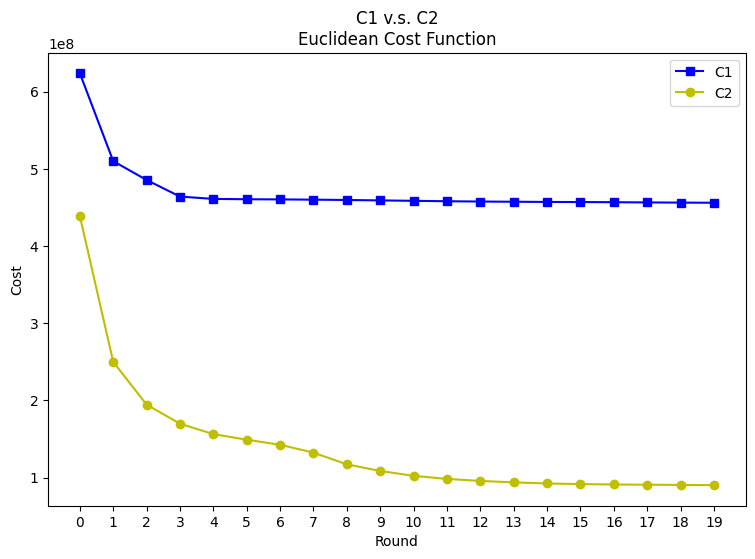

In [17]:
Round = []
for i in range(20):
    Round.append('Round ' + str(i+1))
    
dic = {'C1': euc_c1_cost20, 'C2': euc_c2_cost20}
df = pd.DataFrame(dic, index = Round)
print(df)

Round = []
for i in range(20):
    Round.append(str(i))
    
plt.figure(figsize=(9, 6), dpi = 100, linewidth = 2)
plt.plot(Round, euc_c1_cost20, 's-', color = 'b', label = "C1")
plt.plot(Round, euc_c2_cost20, 'o-', color = 'y', label = "C2")
plt.title('C1 v.s. C2\nEuclidean Cost Function')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.legend(loc = 'best')
plt.show()

## 把所有使用C1的cost union起來

In [18]:
temp_c1 = c1
for i in range(10):
    c1_20 = c1.map(lambda x: (i, x[1]))
    temp_c1 = temp_c1.union(c1_20).reduceByKey(lambda x, y: x + y)

## 計算各個centroid之間的Euclidean距離

In [22]:
euc_c1_euc = temp_c1.map(Euc_Dist).collect()
print(euc_c1_euc)

[[1, 0.0, 692.1578865536187, 3490.2586403239793, 205.75027883457204, 346.71882253414816, 512.6122467083617, 444.7310005470825, 566.2019922936282, 1282.7708445154385, 307.66912835221507], [2, 692.1578865536187, 0.0, 2798.8010531589434, 897.6589863450828, 1038.8268882911389, 1204.0781989863117, 1136.3273438149283, 1257.4495275592424, 669.8902282318555, 412.076077167744], [3, 3490.2586403239793, 2798.8010531589434, 0.0, 3695.114191079636, 3836.9066381524567, 4002.6890825730284, 3934.8715588311575, 4056.1355729719103, 2294.57964158953, 3195.9239010108936], [4, 205.75027883457204, 897.6589863450828, 3695.114191079636, 0.0, 142.43887392408647, 309.50632446700047, 241.7301145044183, 363.2628951046584, 1474.9454213642691, 504.63411599571515], [5, 346.71882253414816, 1038.8268882911389, 3836.9066381524567, 142.43887392408647, 0.0, 167.1498001315246, 99.54554331498562, 220.90178372040566, 1615.852353440387, 646.9305638786212], [6, 512.6122467083617, 1204.0781989863117, 4002.6890825730284, 309.50

## 寫入csv檔

In [23]:
with open('./euc_c1_euc.csv', 'w', newline='') as csvFile:
    fields = ['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in euc_c1_euc:
        writer.writerow({'Euclidean':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

## 計算各個centroid之間的Manhattan距離

In [24]:
euc_c1_man = temp_c1.map(Man_Dist).collect()
print(euc_c1_man)

[[1, 0.0, 728.9243139995409, 3797.8990780180675, 212.18109038688195, 374.8904224625678, 577.4020758222025, 499.1578939470968, 645.7697774866793, 1731.0643066429416, 406.70122510554586], [2, 728.9243139995409, 0.0, 3072.8886904466503, 935.8853379058191, 1100.833091013825, 1303.8957233218873, 1225.351713180189, 1372.0922054892176, 1005.2930456989247, 490.9280581546785], [3, 3797.8990780180675, 3072.8886904466503, 0.0, 4001.0380519416276, 4170.304532612548, 4372.788718801669, 4294.952834221333, 4440.719767637059, 2513.422660256411, 3396.4200031055902], [4, 212.18109038688195, 935.8853379058191, 4001.0380519416276, 0.0, 171.3651541556152, 375.2479208943975, 296.25472354226696, 443.49844537759145, 1934.086959807074, 609.749321623295], [5, 374.8904224625678, 1100.833091013825, 4170.304532612548, 171.3651541556152, 0.0, 204.52292364239253, 125.59678617977005, 272.93491284339433, 2102.8649228110594, 779.3972267080745], [6, 577.4020758222025, 1303.8957233218873, 4372.788718801669, 375.247920894

## 寫入csv檔

In [25]:
with open('./euc_c1_man.csv', 'w', newline='') as csvFile:
    fields = ['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in euc_c1_man:
        writer.writerow({'Manhattan':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

## 把所有使用C2的cost union起來

In [26]:
temp_c2 = c2
for i in range(10):
    c2_20 = c2.map(lambda x: (i, x[1]))
    temp_c2 = temp_c2.union(c2_20).reduceByKey(lambda x, y: x + y) 

## 計算各個centroid之間的Euclidean距離

In [27]:
euc_c2_euc = temp_c2.map(Euc_Dist).collect()
print(euc_c2_euc)

[[1, 0.0, 15760.12247224593, 14110.83439088334, 9045.32023455239, 5567.684524118405, 1924.6240815733204, 1100.8590503593277, 402.89054961102914, 2105.4425755929597, 3169.003772849924], [2, 15760.12247224593, 0.0, 11524.505650179837, 6743.88410019246, 10192.525007384162, 14455.11937212132, 14682.450992891092, 15362.417960805125, 13674.707531226235, 12597.039559531104], [3, 14110.83439088334, 11524.505650179837, 0.0, 9545.879403387185, 10883.382187801386, 12233.959804503613, 13208.002933714424, 13786.484182516106, 12508.95738096874, 11938.376127029482], [4, 9045.32023455239, 6743.88410019246, 9545.879403387185, 0.0, 3494.2224155718104, 7718.222009696623, 7957.775949135465, 8644.807041005524, 6947.820636329124, 5876.330199605868], [5, 5567.684524118405, 10192.525007384162, 10883.382187801386, 3494.2224155718104, 0.0, 4404.562590797219, 4492.458214360271, 5169.9372911256405, 3488.1585187816186, 2407.918794485802], [6, 1924.6240815733204, 14455.11937212132, 12233.959804503613, 7718.22200969

## 寫入csv檔

In [28]:
with open('./euc_c2_euc.csv', 'w', newline='') as csvFile:
    fields = ['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in euc_c2_euc:
        writer.writerow({'Euclidean':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

## 計算各個centroid之間的Manhattan距離

In [29]:
euc_c2_man = temp_c2.map(Man_Dist).collect()
print(euc_c2_man)

[[1, 0.0, 15772.614899885255, 20215.645980206544, 9533.17084939759, 5604.200489099255, 3088.0543184882386, 1311.039156985083, 471.26571999995156, 2369.4121590413606, 3349.657086008631], [2, 15772.614899885255, 0.0, 16003.499, 7219.196666666668, 10221.031, 16105.3475, 14909.169510714286, 15434.460040787624, 13950.575945454546, 12776.883065217391], [3, 20215.645980206544, 16003.499, 0.0, 10690.484333333334, 14613.552, 17509.90275, 18912.605410714285, 19748.93569338959, 17851.806836363638, 16873.243673913043], [4, 9533.17084939759, 7219.196666666668, 10690.484333333334, 0.0, 3935.2926666666663, 8896.389208333332, 8228.355075, 9065.404333333334, 7168.732963636363, 6190.679311594203], [5, 5604.200489099255, 10221.031, 14613.552, 3935.2926666666663, 0.0, 5893.070125, 4696.975382142857, 5221.252805907173, 3737.707, 2564.1705434782607], [6, 3088.0543184882386, 16105.3475, 17509.90275, 8896.389208333332, 5893.070125, 0.0, 1781.8226714285715, 2619.8113862517584, 2162.8021454545456, 3337.74626086

## 寫入csv檔

In [30]:
with open('./euc_c2_man.csv', 'w', newline='') as csvFile:
    fields = ['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in euc_c2_man:
        writer.writerow({'Manhattan':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

## 計算percentage improvement values

In [31]:
euc_c1_improve = abs(euc_c1_cost20[19] - euc_c1_cost20[0]) / euc_c1_cost20[0] * 100
print('C1: ' + str(euc_c1_improve) + '%')
euc_c2_improve = abs(euc_c2_cost20[19] - euc_c2_cost20[0]) / euc_c2_cost20[0] * 100
print('C2: ' + str(euc_c2_improve) + '%')

C1: 26.885383292518288%
C2: 79.43775029159899%


## 以上做完(a)小題
## 以下開始(b)小題
* 作法完全相同，只有計算distance的方式改變，所以就不贅述

In [32]:
c1 = sc.textFile("./hw3-q2-kmeans/c1.txt").map(lambda x: x.split(' ')).map(str_float).groupByKey().mapValues(list)
c2 = sc.textFile("./hw3-q2-kmeans/c2.txt").map(lambda x: x.split(' ')).map(str_float).groupByKey().mapValues(list)
man_c1 = data.join(c1).map(Man_Mapper).groupByKey().mapValues(list)
man_c1_cost = data.join(c1).map(Man_Cost).reduceByKey(lambda x, y: x + y)
man_c2 = data.join(c2).map(Man_Mapper).groupByKey().mapValues(list)
man_c2_cost = data.join(c2).map(Man_Cost).reduceByKey(lambda x, y: x + y)

In [33]:
for i in range(19):
    c1 = man_c1.map(new_centroid).sortByKey(ascending=True).map(lambda x: (-1, x[1])).groupByKey().mapValues(list)
    man_c1 = data.join(c1).map(Man_Mapper).groupByKey().mapValues(list)
    cost = data.join(c1).map(Man_Cost).reduceByKey(lambda x, y: x + y)
    man_c1_cost = man_c1_cost.union(cost)
    if i == 18:
        c1 = man_c1.map(new_centroid).sortByKey(ascending=True).mapValues(list)
man_c1_cost20 = man_c1_cost.map(lambda x: x[1]).collect()
print(man_c1_cost20)

for i in range(19):
    c2 = man_c2.map(new_centroid).sortByKey(ascending=True).map(lambda x: (-1, x[1])).groupByKey().mapValues(list)
    man_c2 = data.join(c2).map(Man_Mapper).groupByKey().mapValues(list)
    cost = data.join(c2).map(Man_Cost).reduceByKey(lambda x, y: x + y)
    man_c2_cost = man_c2_cost.union(cost)
    if i == 18:
        c2 = man_c2.map(new_centroid).sortByKey(ascending=True).mapValues(list)
man_c2_cost20 = man_c2_cost.map(lambda x: x[1]).collect()
print(man_c2_cost20)

[550117.1420000045, 464869.27587929845, 470897.3822772998, 483914.40917334514, 489216.0710034315, 487629.6685499822, 483711.9232137478, 475330.7734932305, 474871.2388463643, 457232.92011507344, 447494.38619734696, 450915.0125766772, 451250.3670725656, 451974.5955397487, 451570.3640699583, 452739.0113664558, 453082.7302871829, 450583.67086030025, 450368.7493167392, 449011.3637255198]
[1433739.3099999938, 1084488.7769648738, 973431.7146620394, 895934.5925630673, 865128.3352940796, 845846.6470313473, 827219.5827561237, 803590.3456011107, 756039.5172761244, 717332.9025432297, 694587.9252526843, 684444.5019967925, 674574.7475478566, 667409.469916026, 663556.6278214998, 660162.777228758, 656041.3222947085, 653036.7540731638, 651112.4262522653, 649689.0131843556]


                     C1            C2
Round 1   550117.142000  1.433739e+06
Round 2   464869.275879  1.084489e+06
Round 3   470897.382277  9.734317e+05
Round 4   483914.409173  8.959346e+05
Round 5   489216.071003  8.651283e+05
Round 6   487629.668550  8.458466e+05
Round 7   483711.923214  8.272196e+05
Round 8   475330.773493  8.035903e+05
Round 9   474871.238846  7.560395e+05
Round 10  457232.920115  7.173329e+05
Round 11  447494.386197  6.945879e+05
Round 12  450915.012577  6.844445e+05
Round 13  451250.367073  6.745747e+05
Round 14  451974.595540  6.674095e+05
Round 15  451570.364070  6.635566e+05
Round 16  452739.011366  6.601628e+05
Round 17  453082.730287  6.560413e+05
Round 18  450583.670860  6.530368e+05
Round 19  450368.749317  6.511124e+05
Round 20  449011.363726  6.496890e+05


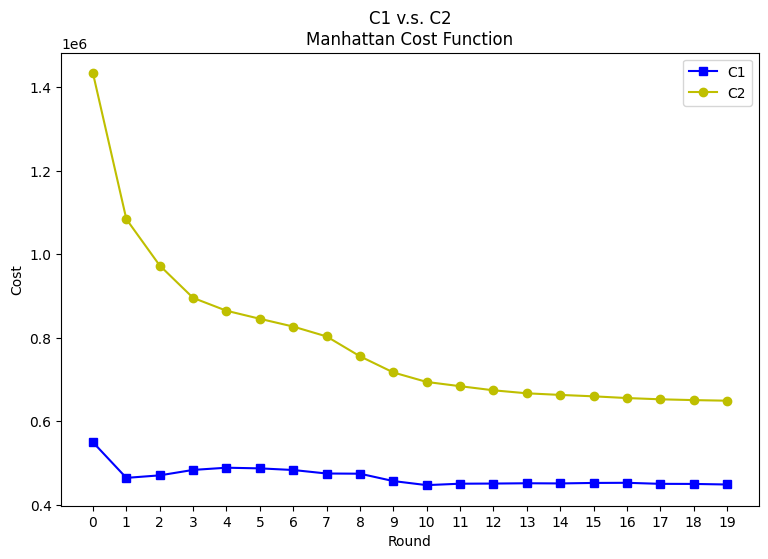

In [34]:
Round = []
for i in range(20):
    Round.append('Round ' + str(i+1))
    
dic = {'C1': man_c1_cost20, 'C2': man_c2_cost20}
df = pd.DataFrame(dic, index = Round)
print(df)

Round = []
for i in range(20):
    Round.append(str(i))
    
plt.figure(figsize=(9, 6), dpi = 100, linewidth = 2)
plt.plot(Round, man_c1_cost20, 's-', color = 'b', label = "C1")
plt.plot(Round, man_c2_cost20, 'o-', color = 'y', label = "C2")
plt.title('C1 v.s. C2\nManhattan Cost Function')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.legend(loc = 'best')
plt.show()

In [35]:
temp_c1 = c1
for i in range(10):
    c1_20 = c1.map(lambda x: (i, x[1]))
    temp_c1 = temp_c1.union(c1_20).reduceByKey(lambda x, y: x + y)
man_c1_euc = temp_c1.map(Euc_Dist).collect()
print(man_c1_euc)
man_c1_man = temp_c1.map(Man_Dist).collect()
print(man_c1_man)

temp_c2 = c2
for i in range(10):
    c2_20 = c2.map(lambda x: (i, x[1]))
    temp_c2 = temp_c2.union(c2_20).reduceByKey(lambda x, y: x + y)
man_c2_euc = temp_c2.map(Euc_Dist).collect()
print(man_c2_euc)
man_c2_man = temp_c2.map(Man_Dist).collect()
print(man_c2_man)

[[1, 0.0, 2219.1772770509865, 9948.044077639335, 528.6997575475606, 413.3650612071161, 827.7188856579816, 681.0349895443137, 917.127382961168, 832.1474343052389, 729.0563485517976], [2, 2219.1772770509865, 0.0, 7767.945602579569, 2734.0498544640413, 2628.4908097297634, 3044.4778721252733, 2898.7128939326617, 3133.460130173686, 1812.4545744763466, 1491.3573457511582], [3, 9948.044077639335, 7767.945602579569, 0.0, 10433.061351319797, 10361.367486044566, 10773.530838116945, 10626.48859681842, 10862.965776276442, 9340.275232170257, 9236.840021697923], [4, 528.6997575475606, 2734.0498544640413, 10433.061351319797, 0.0, 221.37279398782263, 375.1561884837036, 249.3791882654921, 457.25965255434755, 1156.5833757939854, 1251.1583460671166], [5, 413.3650612071161, 2628.4908097297634, 10361.367486044566, 221.37279398782263, 0.0, 415.9899852468605, 270.74879157775905, 505.07106661337866, 1171.964205896139, 1137.135265913954], [6, 827.7188856579816, 3044.4778721252733, 10773.530838116945, 375.15618

In [36]:
with open('./man_c1_euc.csv', 'w', newline='') as csvFile:
    fields = ['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in man_c1_euc:
        writer.writerow({'Euclidean':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})


with open('./man_c1_man.csv', 'w', newline='') as csvFile:
    fields = ['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in man_c1_man:
        writer.writerow({'Manhattan':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

with open('./msn_c2_euc.csv', 'w', newline='') as csvFile:
    fields = ['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in man_c2_euc:
        writer.writerow({'Euclidean':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

with open('./man_c2_man.csv', 'w', newline='') as csvFile:
    fields = ['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()
    for i in man_c2_man:
        writer.writerow({'Manhattan':i[0], '1':i[1], '2':i[2], '3':i[3], '4':i[4], '5':i[5], '6':i[6], '7':i[7], '8':i[8], '9':i[9], '10':i[10]})

In [37]:
man_c1_improve = abs(man_c1_cost20[19] - man_c1_cost20[0]) / man_c1_cost20[0] * 100
print('C1: ' + str(man_c1_improve) + '%')
man_c2_improve = abs(man_c2_cost20[19] - man_c2_cost20[0]) / man_c2_cost20[0] * 100
print('C2: ' + str(man_c2_improve) + '%')

C1: 18.378954327237434%
C2: 54.68569434813374%
